# 4. Findings and Interpretation

#### Alfredo Di Massimo

#### BrainStation, Data Science

#### April 4th, 2022

In this final notebook, we will be interpreting the findings of our best machine learning model to draw out some actionable insights, keeping in mind that the ultimate goal of the project is to better understand what is important to movie-goers who dedicate the time to watch a movie.

___

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import joblib
import dill

# Text data packages
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Model Selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load in the data
movies = joblib.load('movies.pkl')
movies.head()

,primaryTitle,runtimeMinutes,numVotes,sentiment,review,review_word_count,Action,Adult,Adventure,Animation,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,The Student of Prague,85,2054,1,"A good film, and one I'll watch a number of ti...",172,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The Student of Prague,85,2054,1,"In this truly fascinating, dark film, a young ...",292,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,The Student of Prague,85,2054,1,This early version of the tale 'The Student of...,142,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,The Student of Prague,85,2054,1,Those engaging the movie camera so early in th...,165,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,The Student of Prague,85,2054,1,A stupid young man becomes obsessed with a wom...,184,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Assign our features to X 
X = movies.drop(['primaryTitle', 'sentiment'], axis=1)

# Assign our target varibale to y
y = movies['sentiment']

# applying an 80%-20% train-test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    stratify=y, 
                                                    random_state=1)

# Check 
print (f'The shape of the dependent variable: {y_train.shape} & {y_test.shape}')
print (f'The shape of the independent variables: {X_train.shape} & {X_test.shape}')

The shape of the dependent variable: (17534,) & (7515,)
The shape of the independent variables: (17534, 28) & (7515, 28)


### Load in functions required by models

In [4]:
# Load in list of stopwords (found in appendix)
stopwords = joblib.load('stopwords.pkl')

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listoflemmatized_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in stopwords) and (word!=''):
            # Lemmatize words
            lemmatizer = WordNetLemmatizer()
            lemmatized_word = lemmatizer.lemmatize(word)
            listoflemmatized_words.append(lemmatized_word)

    return listoflemmatized_words

In [5]:
def define_col_trans(input_text, vectorizer):
    '''
    Returns a ColumnTransformer which first performs a 
    passthrough on the numeric columns, then applies
    a vectorizer on the `text` column
    
    PARAMETERS:
    - input_text: str, to name the vectorizer tuple
    - vectorizer: Sklearn text vectorizer
    
    RETURNS:
    - col_trans: sklearn ColumnTransformer
    
    '''
    
    # Vectorize text data (cleaned_reviews column) and let everything else pass through
    
    col_trans = ColumnTransformer([
        (input_text, vectorizer, 'review')
    ], 
        remainder='passthrough', 
        sparse_threshold=0)
    
    return col_trans

___

## Model Interpretation

In this section we will load in our best model and inspect the coefficients of words used in positive and negative movie reviews.

In [6]:
# Load in model
fitted_grid = joblib.load('fitted_gridsearch_model.pkl')

To interpret which words provide the most actionable insight, we will analyze the top 20 words with positive coefficients and the top 20 words with negative coefficients.

In [17]:
# start by taking a look at our features created by passing our transformer function in the GridSearch parameters
features = fitted_grid.best_estimator_['transformer'].get_feature_names_out()
features

array(['bow_vec__0', 'bow_vec__0 10', 'bow_vec__007', ...,
       'remainder__Thriller', 'remainder__War', 'remainder__Western'],
      dtype=object)

Before proceeding however, we can determine how many features were generated upon applying the transformer function on our reviews after running the GridSearch.

In [60]:
len(features)

25346

Unfortunately, after applying the tokenizer which included our list of stop words as well as the other parameters used in the Bag of Words vectorizer (min_df=10 to limit our features to tokens that appeared in at least 10 reviews and n_grams=(1, 3), in essence 1 to 3 continuous sequences of words) we are left with over 25,300 features. Our model did not remove as many frequently occurring and invaluable tokens as expected and so this will make interpreting the coeficients of our tokens rather difficult.

Due to how computationally heavy it was to run the GridSearch in our previous notebook, changing the parameters of our tokenizer and our vectorizer to then rerun the module would be inneficient. Rather, knowing the specific hyperparameters of our best model, we can simply run our Logistic Regression using the best estimators determined by our GridSearchCV and apply the changes to our vectorizer manually to reduce the number of columns immediately.

In [240]:
# Determine the best estimator's parameters
print(fitted_grid.best_estimator_)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('bow_vec',
                                                  CountVectorizer(min_df=10,
                                                                  ngram_range=(1,
                                                                               3),
                                                                  tokenizer=<function my_tokenizer at 0x000001DC68D24B80>),
                                                  'review')])),
                ('scaler', StandardScaler()),
                ('model', LogisticRegression(C=0.001))])


In [241]:
# Perform a manual vecotrization using the Bag of Words vectorizer on our reviews

# Instantiate the vectorizer
bagofwords = CountVectorizer(min_df=500, tokenizer=my_tokenizer, ngram_range=(1, 3))

# Fit the vectorizer
bagofwords.fit(X_train['review'])

# Transform our train and test sets
X_train_transformed = bagofwords.transform(X_train['review']) 
X_test_transformed = bagofwords.transform(X_test['review']) 

X_train_transformed.shape

(17534, 590)

We can immediately see that by increasing the min_df value to have words that appear in at least 300 reviews, we've drastically reduced the number of features from over 25,000 to just over 1,000. We can proceed by applying the same Logistic Regression model determined to be the best estimator by our GridSearchCV in order to inspect the highest and lowest coefficients.

In [242]:
logreg = LogisticRegression(C = 0.001)
logreg.fit(X_train_transformed, y_train)

LogisticRegression(C=0.001)

In [243]:
# Assign the features from our BoW to a variable to be able to plot our top and bottom 20 words
words = bagofwords.get_feature_names()

In [244]:
# We can store the tokens from our model as well as their coefficients into a dataframe
coef_df = pd.DataFrame({"coefficient": logreg.coef_[0], "token": words})

# Sort the tokens based on their coefficients in descending order
coef_df = coef_df.sort_values("coefficient", ascending=False)

# Store the top and bottom 20 words in our dataframe into their own dataframes for plotting
top_20_words = coef_df.sort_values('coefficient', ascending=False).head(20)
bot_20_words = coef_df.sort_values('coefficient', ascending=True).head(20)

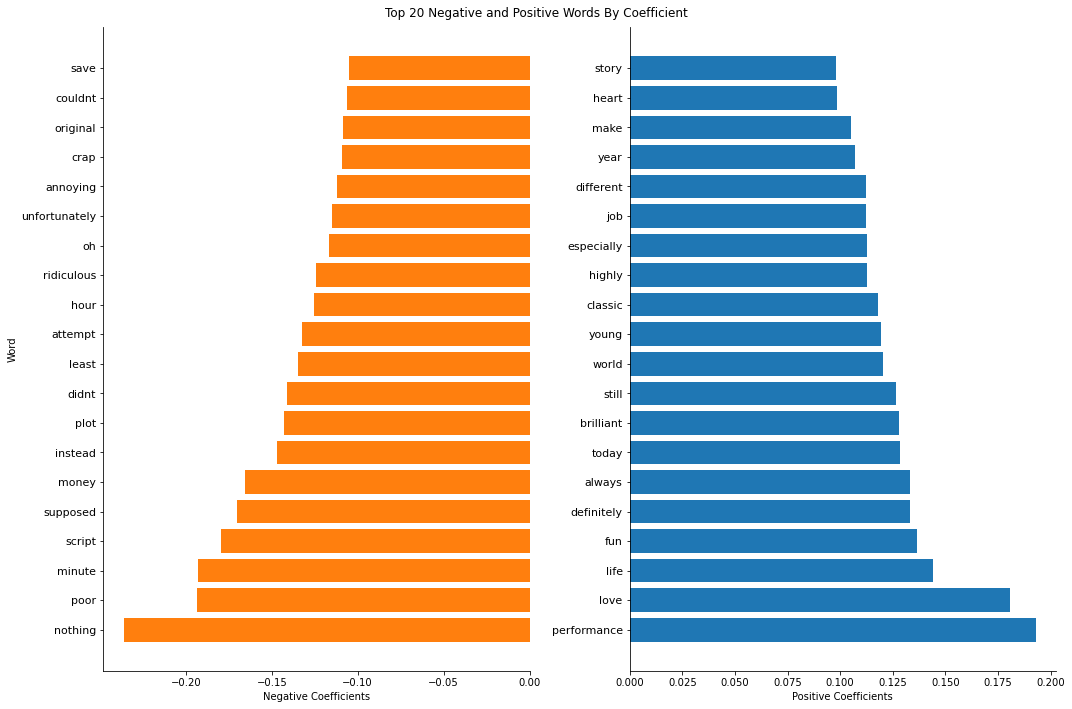

In [245]:
# plot top and bottom 20 words
plt.subplots(1,2, figsize=(15,10))

plt.subplot(1,2,1)
plt.barh(bot_20_words['token'], bot_20_words['coefficient'], color='tab:orange' )
plt.xlabel('Negative Coefficients')
plt.ylabel('Word')
plt.yticks(fontsize=11)

plt.subplot(1,2,2)
plt.barh(top_20_words['token'], top_20_words['coefficient'])
plt.xlabel('Positive Coefficients')
plt.yticks(fontsize=11)
plt.suptitle('Top 20 Negative and Positive Words By Coefficient')

sns.despine()
plt.tight_layout()
plt.savefig('Top and Bottom 20 Words.png', bbox_inches='tight')
plt.show()

We can reapply the Logistic Regression model to inspect the coefficients of our non-text columns as well.

In [246]:
# Assign our features to X 
X2 = movies.drop(['primaryTitle', 'sentiment', 'review'], axis=1)

# Assign our target varibale to y
y2 = movies['sentiment']

# applying an 80%-20% train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, 
                                                    y2, 
                                                    test_size=0.3, 
                                                    stratify=y, 
                                                    random_state=1)

# Instantiate the scaler
SS = StandardScaler()

# Fit the scaler
SS.fit(X2_train)

# Transform the training and test sets 
X2_train_ss = SS.transform(X2_train)
X2_test_ss = SS.transform(X2_test)

logreg2 = LogisticRegression(C = 0.001)
logreg2.fit(X2_train_ss, y2_train)

LogisticRegression(C=0.001)

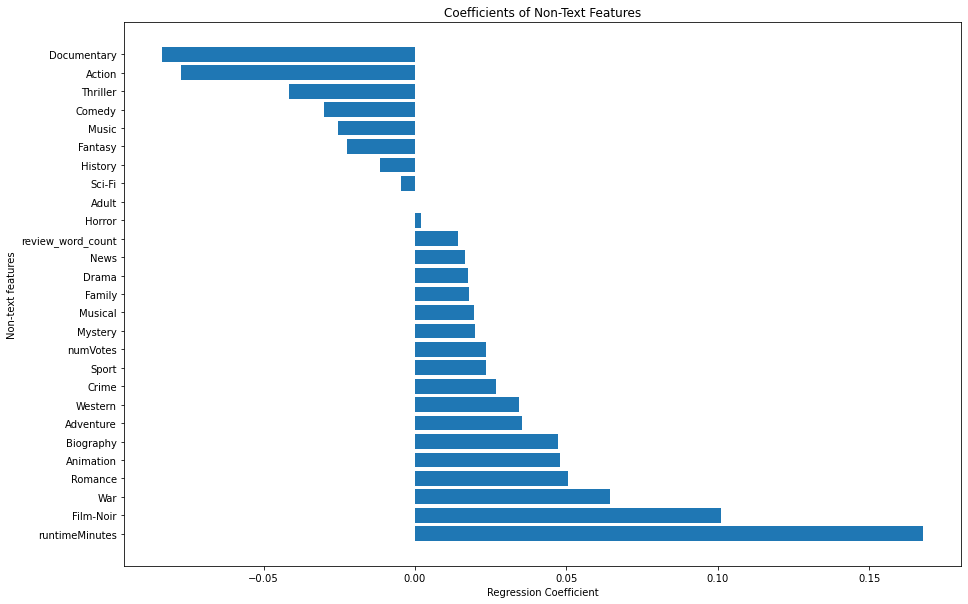

In [247]:
coef_df2 = pd.DataFrame({"coefficient": logreg2.coef_[0], "feature": X2.columns})
coef_df2 = coef_df2.sort_values("coefficient", ascending=False)

# Plot coefficient of non-text features
plt.figure(figsize=(15,10))
plt.barh(coef_df2['feature'], coef_df2['coefficient'])
plt.title('Coefficients of Non-Text Features')
plt.xlabel('Regression Coefficient')
plt.ylabel('Non-text features')
plt.savefig('Coefficients of Non-Text Features.png', bbox_inches='tight')
plt.show()

___

## Conclusion: Interpretation and Actionable Insights

### Positive Words

While many of the tokens listed portray a general sense of satisfaction towards the movie being reviewed, there are some words that stand out from which we can gain some insight into the reviewers thoughts:
- **Performance**: Here it's clear that the performance given by the actors is the most important factor when assessing whether a movie is considered "good" or "bad". This coincides with the token **"acting"** appearing earlier in the wordcloud from notebook 2, indicating that the cast chosen for a movie is particularly important to movie-goers. This can indicate that directors should allocate a significant portion of the funds available on the cast hired to act in a movie.
- ***Specific Adjectives***: While many adjectives were excluded from considerationdue to their inherently positive or negative nature (ie.: terrific, terrble) severl adjectes provide insight into what the consumer was feeling or what caused them to feel that a movie was "good". We can see the strong impact that words like **fun**, **brilliant** and even **different** had on predicting the sentiment behind a review. Using such words in promotional material can further increase the likelihood that a consumer would be interested in paying an admission fee to watch a movie.
- **Story**: Unsurprisingly, a movie's plot is a key feature for reviewers when expressing whether they thought a movie was "good" or "bad".

### Negative Words

The words used for movies perceived as being "bad" can be interpreted as follows:
- **Script** & **plot**: being two closely related words with some of the lowest coefficients, **Script** & **plot** indicate that reviewers placed great importance on the story the movie, but were disappointed. Knowing this, directors can place a greater emphasis on ensuring that the quality of a movie's script is well received prior to the release of a movie. This can be done by allocating more financial resources towards studying a specific theme addressed by the movie or perhaps hiring an expert in a given field. This specific sentiment coincides with the token **story** appearing as one of the top 20 words discussed above.
- ***Specific Adjectives***: As with positive reviews, some specific adjectives used in "bad" reviews can give us some insight into why reviewers were dissatisfied after watching a movie. Terms such as **nothing**, **dull** and **poor** imply that the movie left the consumer wanting, that there was a lack of something in their experience. When contrasting with the positive adjectives used, it seems that movies are more likely to receive a negative review if they fail to draw out a powerful emotional experience within viewers.

### Non-Text Features

We can see in the *'Coefficients of Numeric Features'* plot that a movie's **runtimeMinutes** has the greatest impact on the reviewer's sentiment implying that longer movies are more well-received by movie goers. Contrary to earlier expectations however, the length of a review measured by the **review_word_count** has hardly any effect on the sentiment score behind a review; contrary to what I believed from personal experience of reading reviews, longer reviews cannot necessarily be associated with a reviewers sentiment.<br/>

It is interesting to note the vast difference in coefficients between the genres of a movie and their impact on the sentiment. **Drama** being the most frequently occurring genre within our dataset has a surprisingly low impact on reviewer sentiment whereas **Film-Noir** and **Documentary** being the least frequently occurring genres have the highest impact. This can very possibly be due to an imbalance in the distribution of the genres within the dataset.

## What's Next?

- Run additional machine learning models: I would be interested in running neural networks and use word embeddings to further determine if we can improve our predictive capability.
- Use the unlabeled reviews provided in the dataset to perform unsupervised machine learning;
- Further improve our existing models by optimizing them;
- Improve our vectorizer and transformer functions by applying more stringent token reduction techniques
- Determine significant themes in positive and negative words that apply to specific genres (a uniform distribution of our genres would be required.)